<a href="https://www.kaggle.com/code/hanpat99/indian-liver-patients-classification?scriptVersionId=133030993" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Problem Statement
Download the Liver patient data from the following sources:

https://www.kaggle.com/uciml/indian-liver-patient-records

Use the following 07 features from this dataset:
* Age; 
* Total_Bilirubin; 
* Direct_Bilirubin; 
* Alkaline_Phosphotase;
* Alamine_Aminotransferase;
* Total_Protiens; 
* Albumin

Your task is to predict whether a patient suffers from a liver disease using above
features. Split your data into test and train.
First use a random forest algorithm for performing this task.
Then, use a Adaboost Classifier to perform similar task.
Compare the accuracy of these two algorithms.

# 1.0.1 Dataset context

The Indian Liver Patients Dataset is generated from a study done on liver patients in the North East region of Andhra Pradesh, India. This region, where I come from, sees a high rate of alcohol abuse, which is a leading cause of liver health issues. 

This region also typically sees males consuming more alcohol than females, so we may expect to see a higher prevalance of liver disorders among males than in females. The feature descriptions are self-explanatory, so let's dive into the addressing the problem at hand.

The problem relates to predicting whether a subject suffers from a liver disease, based on liver function diagnostic results. There are 167 healthy subjects and 416 patients in this dataset, encoded as 2 & 1, respectively. I will train and compare the performances of two different Advanced Machine Learning Classifiers - AdaBoostClassifier and RandomForestClassifier, for this purpose.

# 1.0.2 Workflow:



1. Loading the dataset
2. Preprocessing and EDA: Missing Values handling, Feature Engineering
3. Model Training, Hyperparameter Tuning and Evaluation
4. Conclusion: Comparison of Estimators




# 1.1 Import block and loading the dataset


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set plot style
sns.set(color_codes=True)
%matplotlib inline
plt.rcParams['figure.figsize']=15,8
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
liv = pd.read_csv('/kaggle/input/indian-liver-patient-records/indian_liver_patient.csv')

In [ ]:
liv.rename(columns = {'Dataset':'liver_disease_YN'}, inplace =True)

In [ ]:
df = liv.copy()

# 1.2  Preprocessing and EDA: Missing Values handling, Feature Engineering

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.liver_disease_YN.value_counts() #416 diseased and 167 healthy

# 1.2.1 Duplicates

In [ ]:
df.duplicated().sum()

In [ ]:
df[df.duplicated()== True]

Since there is no unique patient identifier against each observation, and since it is highly improbable that two subjects have the same exact feature values, its safe to say that these records are possibly duplicates. I will remove these. 

In [ ]:
df = df.drop_duplicates().reset_index().drop('index', axis = 1)

# 1.2.2 Missing Values

In [ ]:
df.isna().sum()

In [ ]:
df[df.Albumin_and_Globulin_Ratio.isna()]

#### I'll encode the Gender feature and impute missing values in the Albumin_and_Globulin_Ratio.

In [ ]:
## Feature encoding
gender_replace_dict = {'Male':0, 'Female':1}
df.replace(gender_replace_dict, inplace = True)

## Original dataframe has 1 & 2 encoding for whther a subject has liver disease or not, respecively. 
## I will change this into a binary 0 & 1 feature
target_replace_dict = {1:1, 2:0} 
df['liver_disease_YN'].replace(target_replace_dict, inplace = True)

In [ ]:
## Missing value imputation
median_AG_ratio_by_gender = df.groupby('Gender')['Albumin_and_Globulin_Ratio'].median()
print(median_AG_ratio_by_gender)
df['Albumin_and_Globulin_Ratio'] = df['Albumin_and_Globulin_Ratio'].fillna(df['Gender'].map(median_AG_ratio_by_gender))

# 1.2.3 Outlier Handling

I've initially considered 2 possible strategies for outlier handling: 

1. Dropping rows with outliers
2. Log Normalization

I'm going ahead with log-normalization as dropping rows in a small dataset such as this is undesirable. I will still look at outlier counts for continuous features and their proportions.

**1. Dropping rows with outliers**

In [ ]:
continuous_features = df.drop(['Gender', 'liver_disease_YN'], axis=1)

In [ ]:
## Male: 0, Female: 1, 
## doesnt have liver disease: 0, has liver disease : 1, 
print('Outliers % across continuous features across the 4 sub-groups')


# Create an empty set to record outlier row indices
outlier_indices1 = set()
outlier_indices2 = set()
outlier_indices3 = set()
outlier_indices4 = set()
df1 = df[(df.Gender == 0) & (df.liver_disease_YN == 0)] ## Male, No Disease
df2 = df[(df.Gender == 1) & (df.liver_disease_YN == 0)] ## Female, No Disease
df3 = df[(df.Gender == 0) & (df.liver_disease_YN == 1)] ## Male, Disease
df4 = df[(df.Gender == 1) & (df.liver_disease_YN == 1)] ## Female, Disease


## Male, No Disease
# Iterate through continuous features
for feature in continuous_features.columns:
    mean = df1[feature].mean()
    std = df1[feature].std()
    outliers = df1[(df1[feature] < mean - 2*std) | (df1[feature] > mean + 2*std)].index
    outlier_indices1.update(outliers)
print(f'Male, No Disease:  {len(outlier_indices1)/df1.shape[0]:.2f}, Count: {len(outlier_indices1)}')


## Female, No Disease
for feature in continuous_features.columns:
    mean = df2[feature].mean()
    std = df2[feature].std()
    outliers = df2[(df2[feature] < mean - 2*std) | (df2[feature] > mean + 2*std)].index
    outlier_indices2.update(outliers)
print(f'Female, No Disease:  {len(outlier_indices2)/df2.shape[0]:.2f}, Count: {len(outlier_indices2)}')


## Male, Disease
# Iterate through continuous features
for feature in continuous_features.columns:
    mean = df3[feature].mean()
    std = df3[feature].std()
    outliers = df3[(df3[feature] < mean - 2*std) | (df3[feature] > mean + 2*std)].index
    outlier_indices3.update(outliers)
print(f'Male, Disease:  {len(outlier_indices3)/df3.shape[0]:.2f}, Count: {len(outlier_indices3)}')


## Female, Disease
# Iterate through continuous features
for feature in continuous_features.columns:
    mean = df4[feature].mean()
    std = df4[feature].std()
    outliers = df4[(df4[feature] < mean - 2*std) | (df4[feature] > mean + 2*std)].index
    outlier_indices4.update(outliers)
print(f'Female, Disease:  {len(outlier_indices4)/df4.shape[0]:.2f}, Count: {len(outlier_indices4)}')

In [ ]:
total_outliers = outlier_indices1.union(outlier_indices2).union(outlier_indices3).union(outlier_indices4)

In [ ]:
df_outliers_dropped = df.drop(total_outliers)
print(df_outliers_dropped.shape)

In [ ]:
df_outliers_dropped.skew()

In [ ]:
df_outliers_dropped = df_outliers_dropped.reset_index().drop('index', axis = 1)

**2. Log Normalization of skewed features**

In [ ]:
df.skew()

#### Some features like Total_Bilirubin, Direct_Bilirubin, Alkaline_Phosphotase, Alamine_Aminotransferase, Aspartate_Aminotransferase are heavily skewed to the right, probably due to outliers. Lets log-normalize these features to improve model performance.

In [ ]:
## Adding new log transformed features and visualizing their distributions

skewed_features = ['Total_Bilirubin',\
                   'Direct_Bilirubin', \
                   'Alkaline_Phosphotase', \
                   'Alamine_Aminotransferase', \
                   'Aspartate_Aminotransferase']

fig = plt.figure(figsize=(15,3))

print('Skewness of log transformed features:')
for idx, feature in enumerate(skewed_features):
    new_name = f'log_{feature}'
    df[new_name] = np.log10(df[feature]+1) #add 1 to features with 0 values to prevent -np.inf during log transform  
    print(new_name, ':\t', df[new_name].skew())

    sub = fig.add_subplot(1,5,idx+1) 
    sub.set_xlabel(f'log_10_{feature}')
    df[new_name].plot(kind='hist')
    plt.tight_layout()

In [ ]:
df = df.drop(skewed_features, axis = 1)

# 1.2.4 Univariate Analysis

In [ ]:
df.columns

In [ ]:
df_outliers_dropped.columns

In [ ]:
## Lets visualize the distributions of our features

fig = plt.figure(figsize = (18,12))

for idx, feature in enumerate(df.columns):
    sub = fig.add_subplot(5,5,idx+1)
    sub.set_xlabel(feature)
    df[feature].hist()
    plt.tight_layout()


In [ ]:
## df_outliers_dropped
## Lets visualize the distributions of our features

fig = plt.figure(figsize = (18,12))

for idx, feature in enumerate(df_outliers_dropped.columns):
    sub = fig.add_subplot(5,5,idx+1)
    sub.set_xlabel(feature)
    df_outliers_dropped[feature].hist()
    plt.tight_layout();


#### This is interesting. The following observations can be made from these plots.


1.   The median age of the participants is in the late 40s to early 50s range.
2.   More males have participated than females in the Liver health study. 
3. My initial hypothesis was that males in this geographical region have been facing higher amount of liver issues. Let's find out if this is the case in the next set of visualizations.
4. We do not have baseline values for healthy people in the dataset's Kaggle page, nor in the feature descripion. I will attempt to find this out using the groupby function for healthy livers (df.liver_disease_YN == 0).

In [ ]:
## Artificial Baseline, Mean (not verified against medical standards)
baseline_avg = df_outliers_dropped[df_outliers_dropped.liver_disease_YN == 0].groupby('Gender').mean()
baseline_avg

In [ ]:
df_outliers_dropped[df_outliers_dropped.liver_disease_YN == 1].groupby('Gender').mean()

#### The above mean values seems very off, with significantly different values for Males and Females. Since mean is susceptible to outliers, lets redo this with median and compare the baseline median values of healthy subjects against subjects with liver disease (df.liver_disease_YN == 1).


In [ ]:
## Artificial Baseline, Median (not verified against medical standards)
baseline_median = df_outliers_dropped[df_outliers_dropped.liver_disease_YN == 0].groupby('Gender').median()
baseline_median

In [ ]:
df_outliers_dropped[df_outliers_dropped.liver_disease_YN == 1].groupby('Gender').median()

#### Observations:
1. A simple visual comparison between the median tables reveals that in general, people with liver issues have higher feature medians than those with healthy livers, for both genders.
2. Albumin to Globulin ratio is lower for those with liver disease, for both genders.
3. The median age for those with liver disease is higher for both genders.
4. Females in the test group are susceptible to liver disease at a younger age than males. 
5. On a whole, this seems to indicate that older population in the region are more susceptible to liver disease. Could this be because of poor socio-economic conditions, access to disposable incomes leading to alcohol abuse, shortage of medical services?

#### Let's verify the above observations visually, and understand the distribution of features across the binary groups, Gender and Liver Disease.

In [ ]:
print(gender_replace_dict)

for feature in df.drop(['Gender', 'liver_disease_YN'],axis=1).columns:
    plt.figure(figsize=(3,4))
    sns.boxplot(df, x = 'Gender', y = feature, notch = True, flierprops={"marker": "x"},
                showcaps=False, medianprops={"color": "coral"}, hue = 'liver_disease_YN', dodge = True) #customizing the boxplots
    fig.savefig(f'barplot_{feature}_gender.png', bbox_inches='tight')
    plt.show();

In [ ]:
## df_outliers_dropped
print(gender_replace_dict)

for feature in df_outliers_dropped.drop(['Gender', 'liver_disease_YN'],axis=1).columns:
    plt.figure(figsize=(3,4))
    sns.boxplot(df_outliers_dropped, x = 'Gender', y = feature, notch = True, flierprops={"marker": "x"},
                showcaps=False, medianprops={"color": "coral"}, hue = 'liver_disease_YN', dodge = True) #customizing the boxplots
    fig.savefig(f'barplot_{feature}_gender.png', bbox_inches='tight')
    plt.show();

#### Observations
1. Within each gender, feature medians tend to be higher for those with liver disease as opposed to healthy subjects. An excpetion to this is 2 features - Albumin, Albumin-Globulin ratio, where diseased subjects tend to score lower.

2. The feature 'Total_Protiens' doesn't provide additional insights within the gender groups, and across the target (diseased or not) groups.

3. The features log_direct_bilirubin and log_total_bilirubin show a significant difference in liver health status across both genders, and higher feature values seem to correspond towards having liver problems.

3. There's too much of an overlap of the Inter Quartile Range of the barplots to infer conclusively, that any of the features influence liver disease for either genders. I suspect a one-way ANOVA test between the named groups would give different insights, so I'll move forward with the analysis.

# 1.2.5 Multivariate Analysis

<Figure size 1600x2000 with 0 Axes>

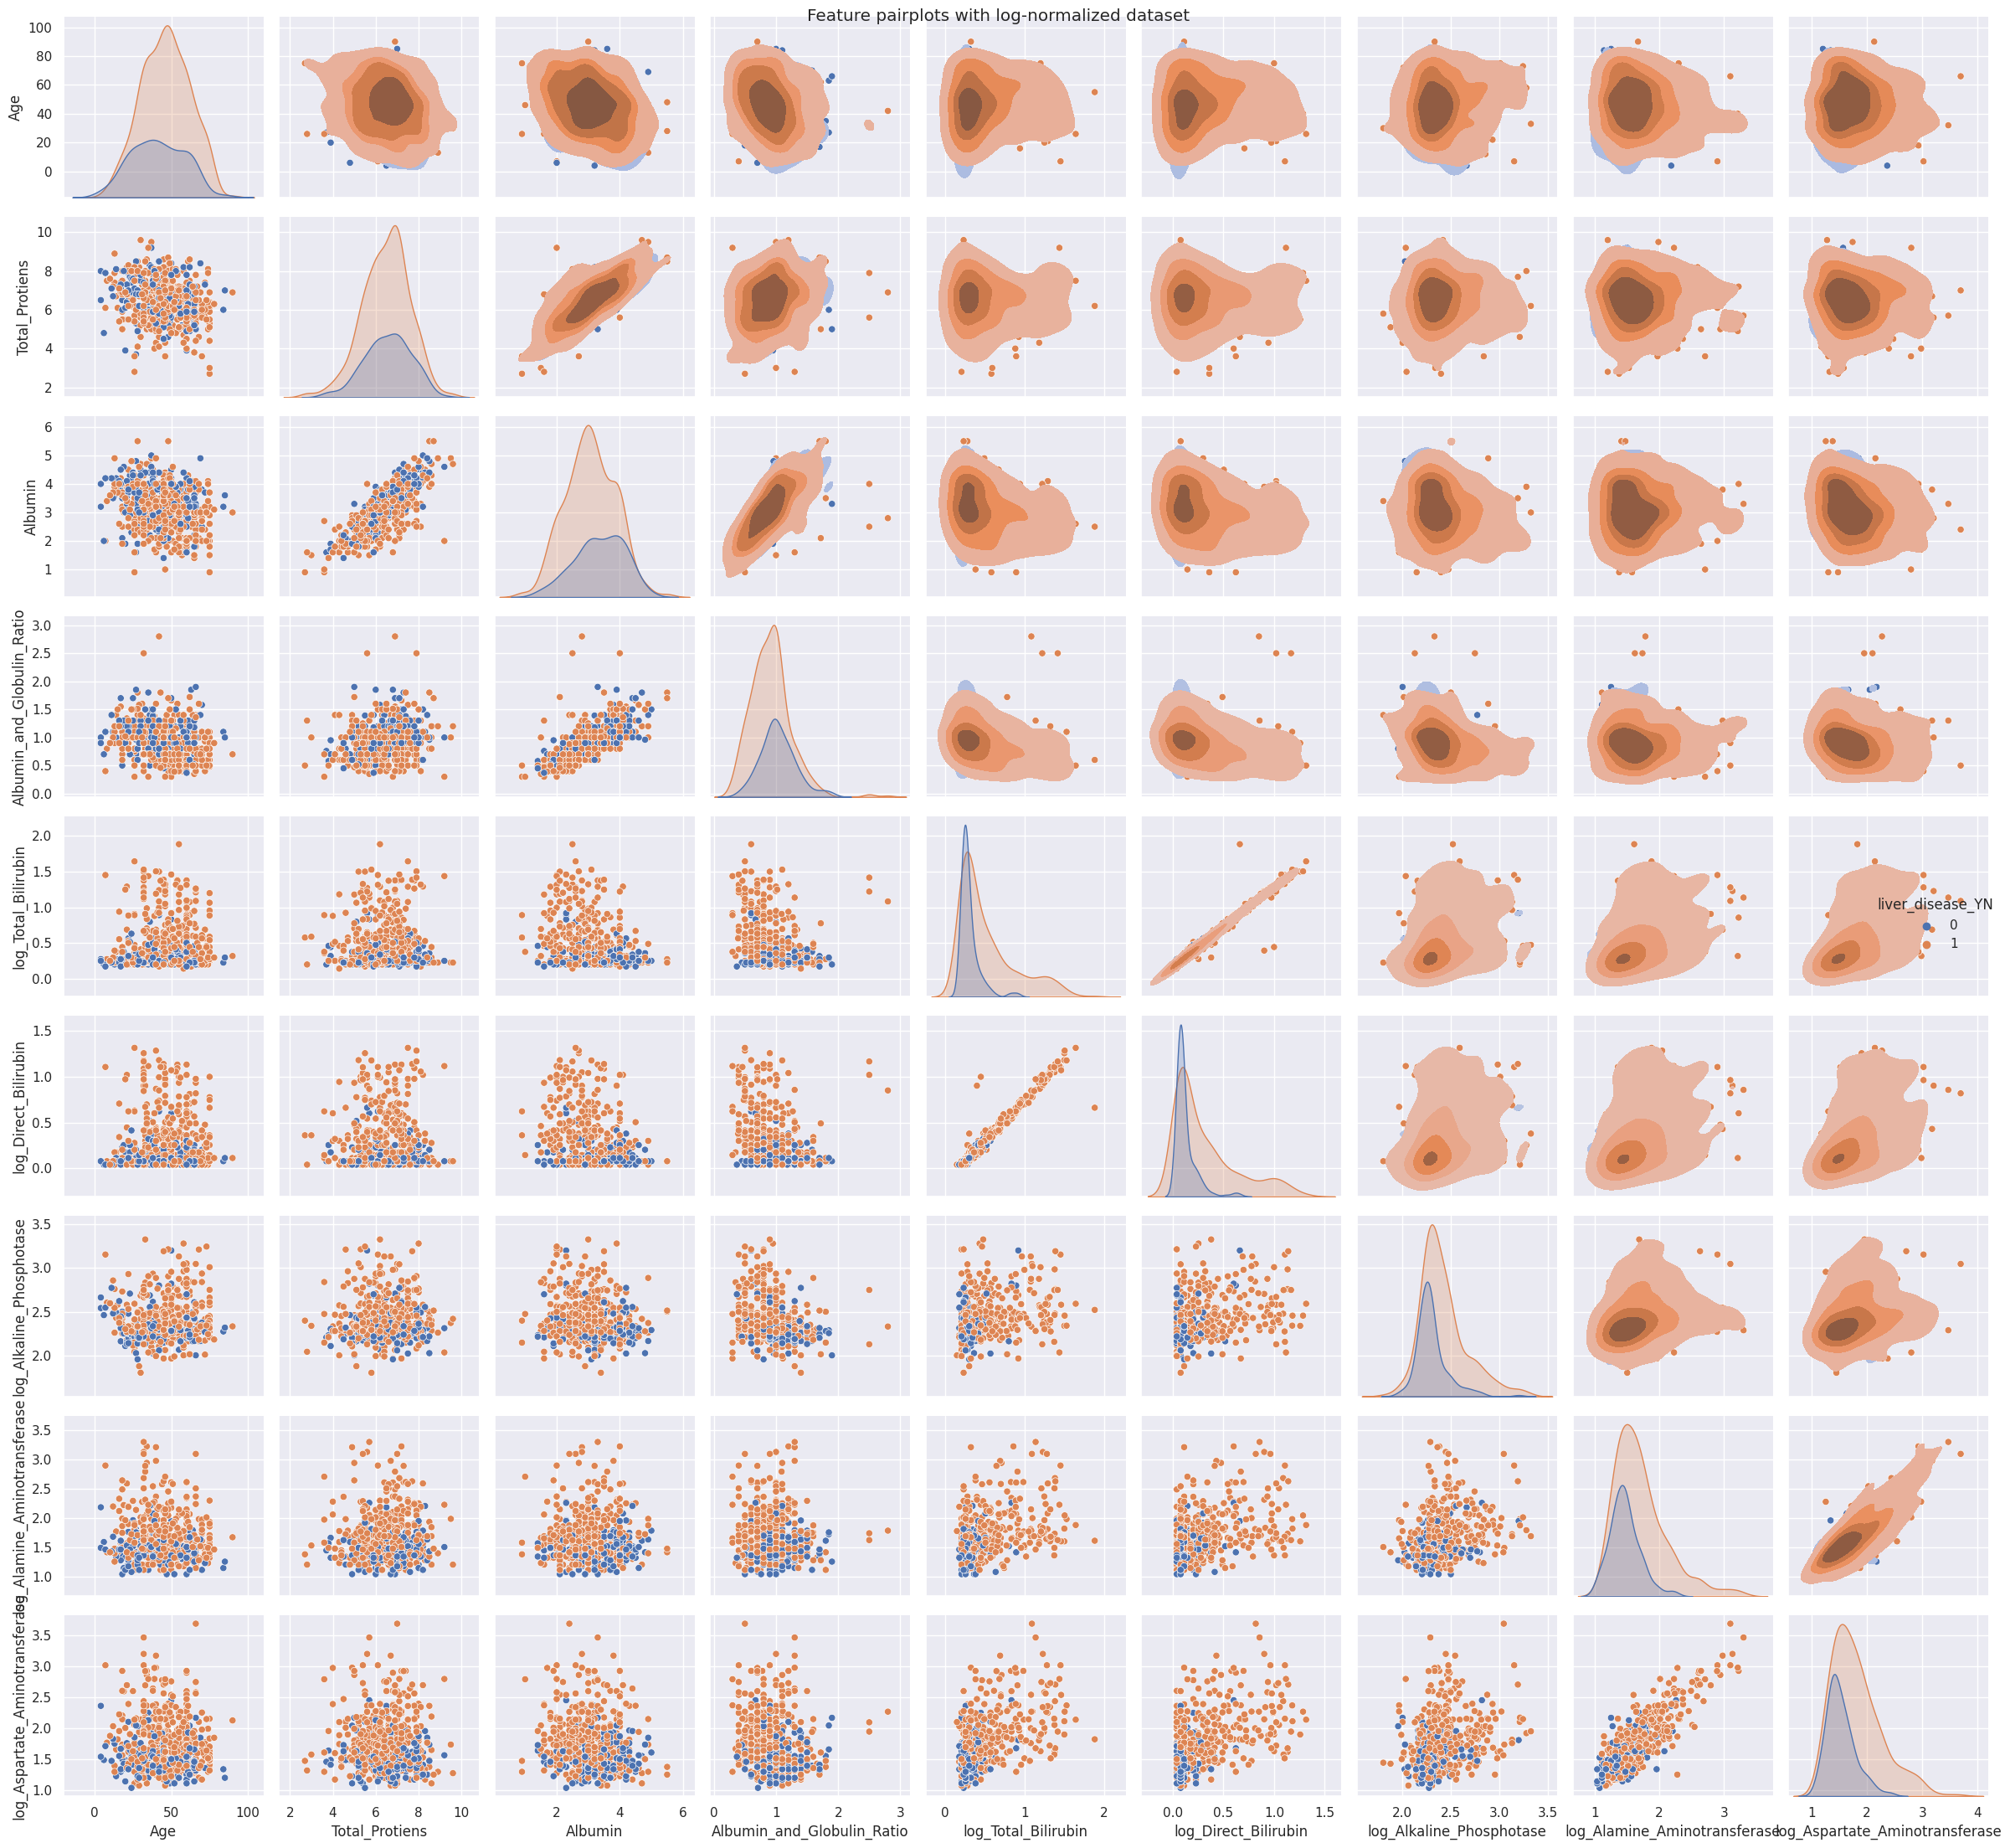

In [81]:
plt.figure(figsize=(16,20))
g = sns.pairplot(df.drop('Gender', axis = 1), hue = 'liver_disease_YN')
g.map_upper(sns.kdeplot, levels = 5, hue = df['liver_disease_YN'], fill = True)
plt.suptitle('Feature pairplots with log-normalized dataset')
plt.tight_layout()
plt.show();

<Figure size 1600x2000 with 0 Axes>

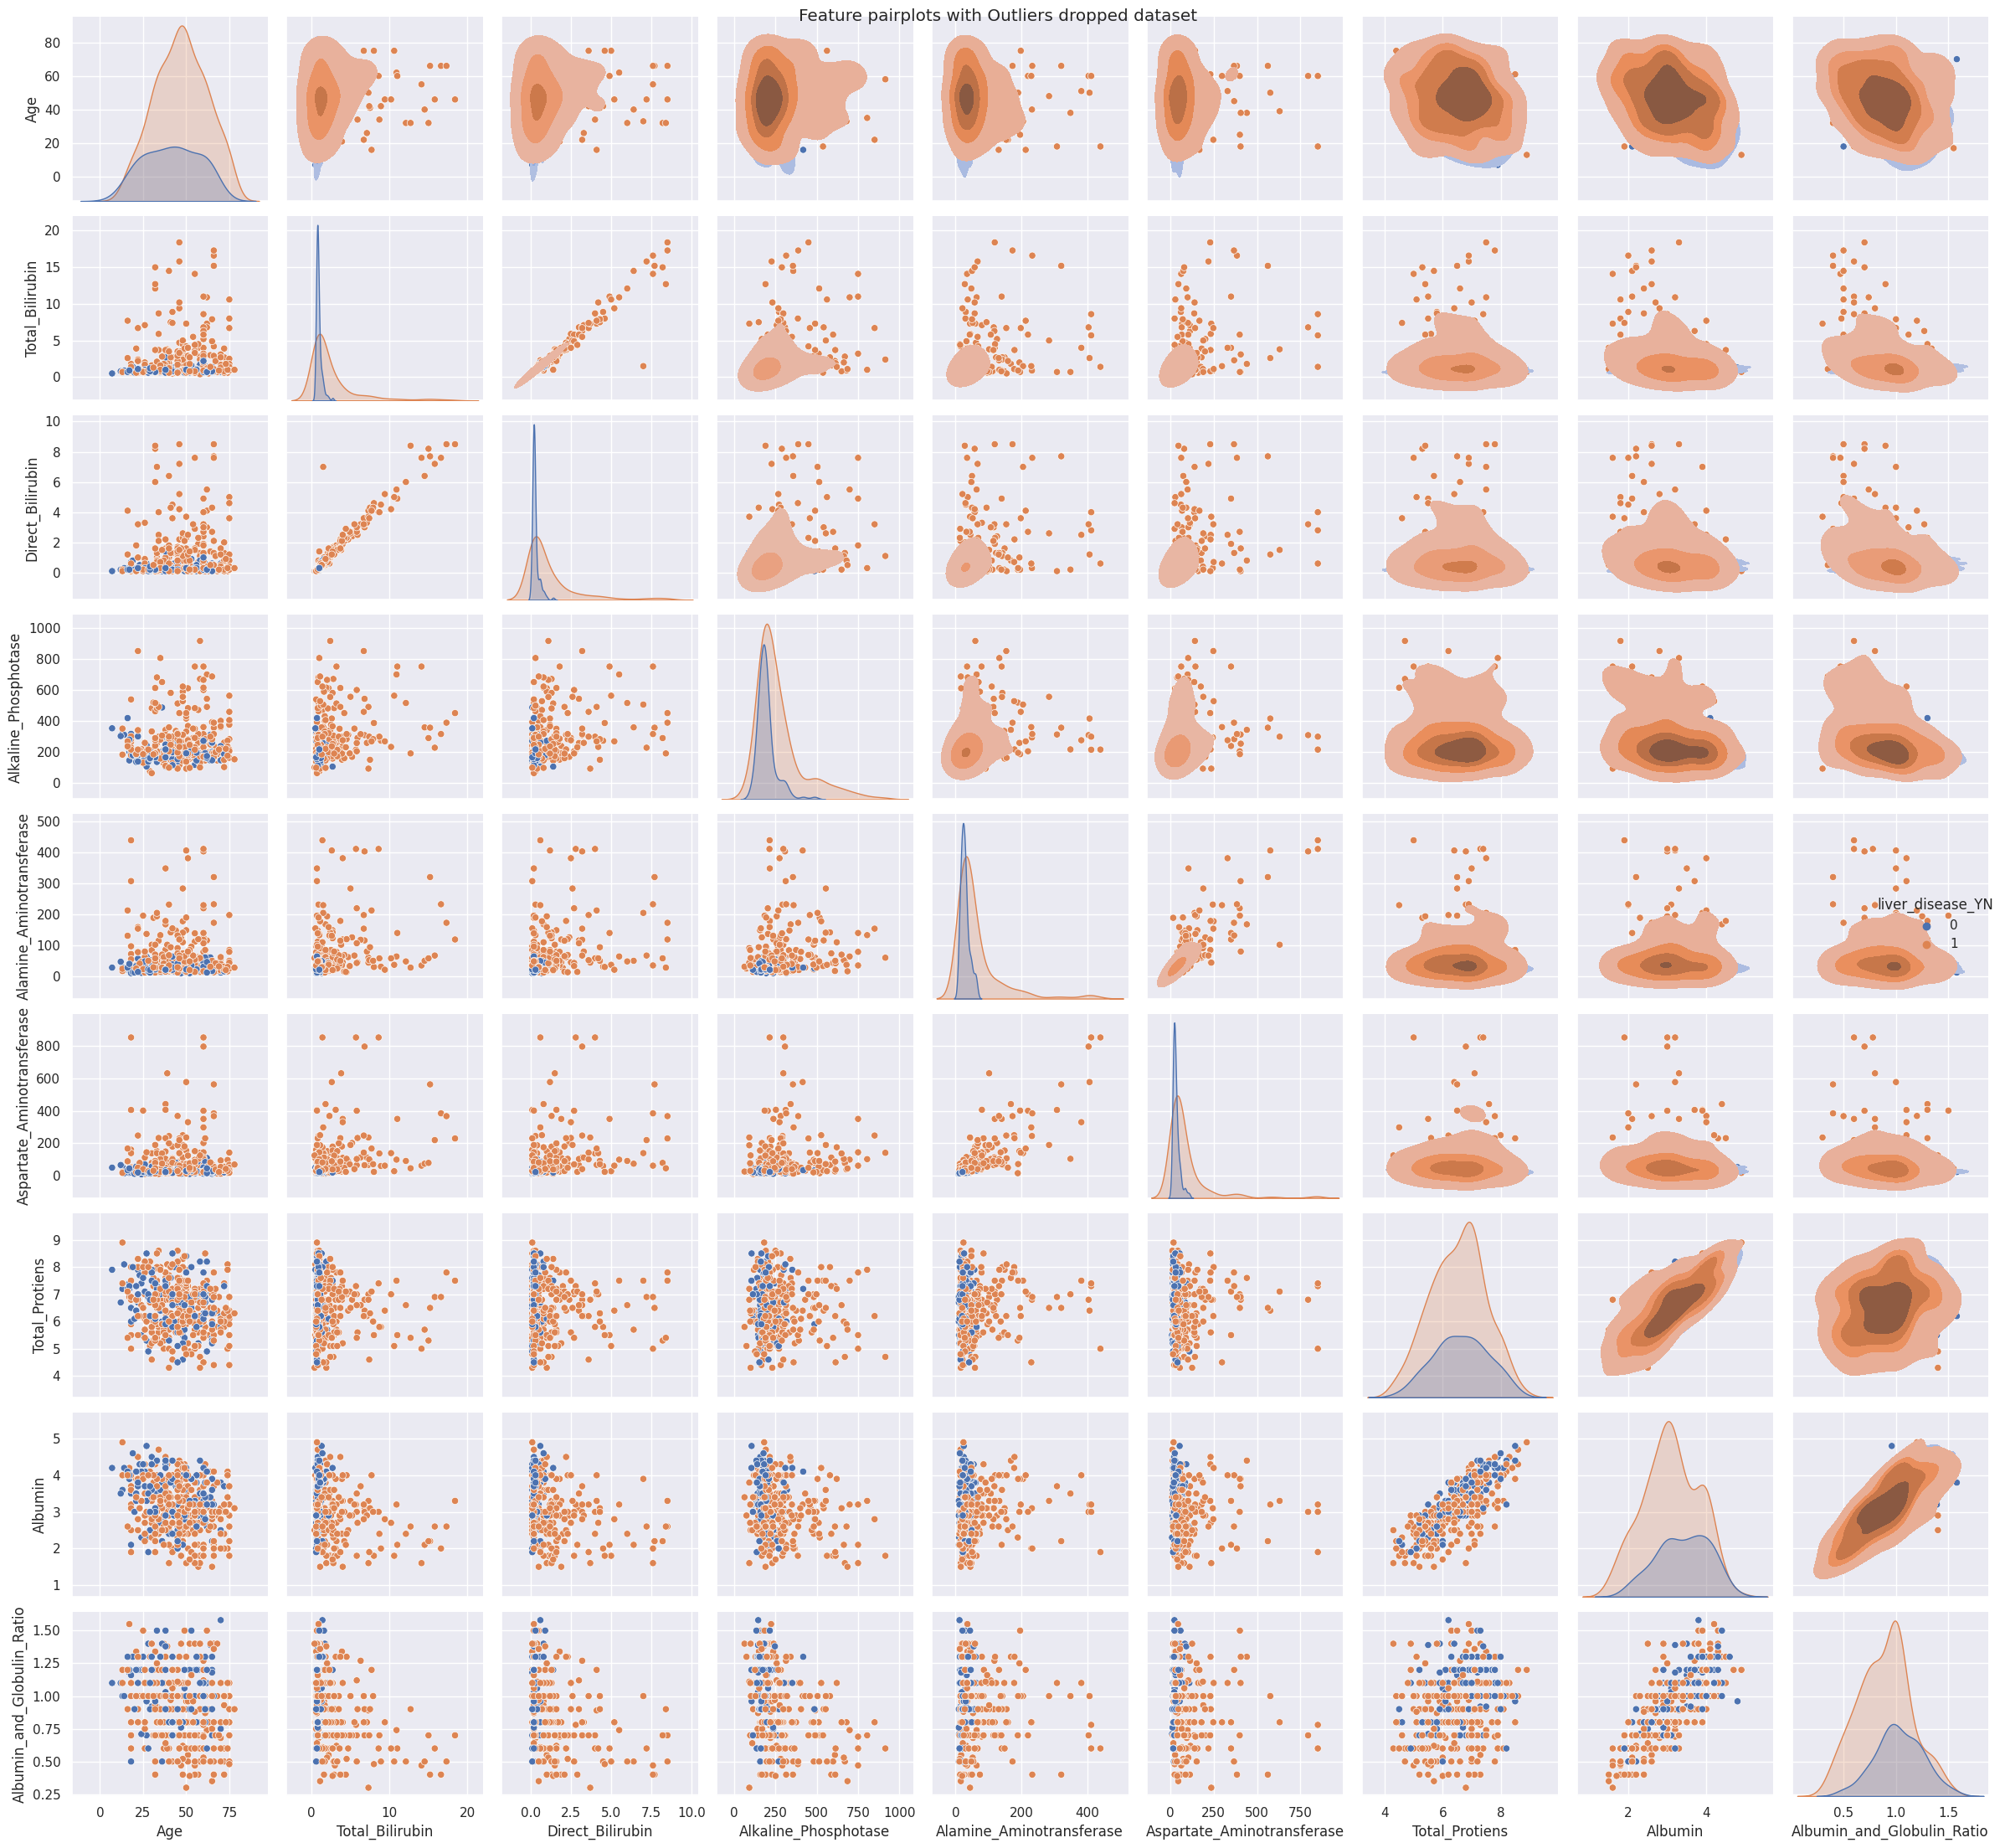

In [82]:
## df_outliers_dropped
plt.figure(figsize=(16,20))
g = sns.pairplot(df_outliers_dropped.drop('Gender', axis = 1), hue = 'liver_disease_YN')
g.map_upper(sns.kdeplot, levels = 5, hue = df_outliers_dropped['liver_disease_YN'], fill = True)
plt.suptitle('Feature pairplots with Outliers dropped dataset')
plt.tight_layout()
plt.show();

#### The pairplot reveals some interesting trends in the data.
1. Only 4 feature pairs exhibit a strong collinearity.
2. The remaining pairplots do not seem to show any trends.

I will verify this with a correlation map.

In [83]:
def corr_map(df, title, method='spearman', numeric_only = True, tick_size = 10, annot_size=10, annot_kws=10):
    mask = np.triu(np.ones_like(df.corr(method=method,numeric_only=numeric_only), dtype=bool))
    heatmap = sns.heatmap(df.corr(method=method, numeric_only = numeric_only), fmt = '.2f',  annot = True, annot_kws = {'size': annot_kws}, mask=mask, cmap='BrBG')#
    plt.xticks(rotation=80, fontsize= tick_size)
    plt.yticks( fontsize= tick_size)
    
    heatmap.set_title(title, fontdict={'fontsize':annot_size}, pad=12)
    plt.show();

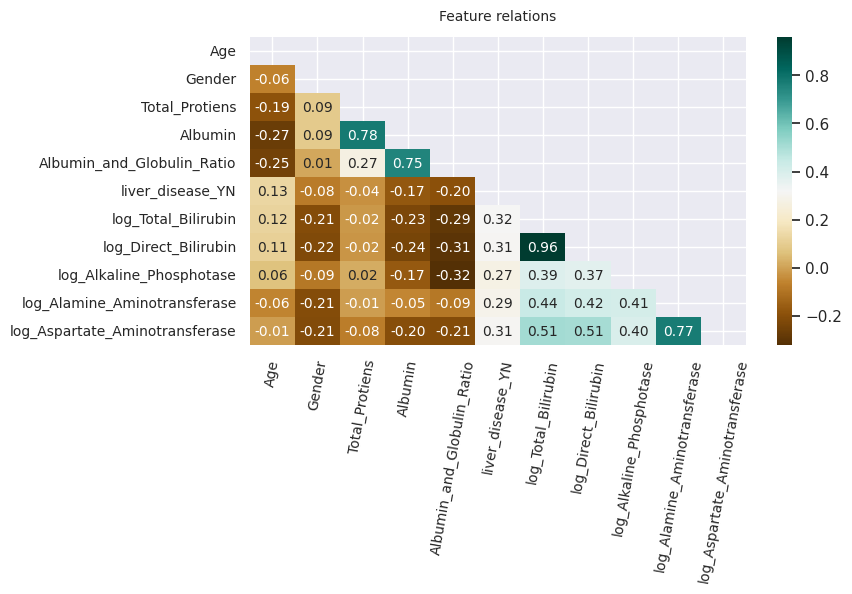

In [84]:
plt.figure(figsize=(8, 4))
corr_map(df, 'Feature relations in log-normalized dataset')

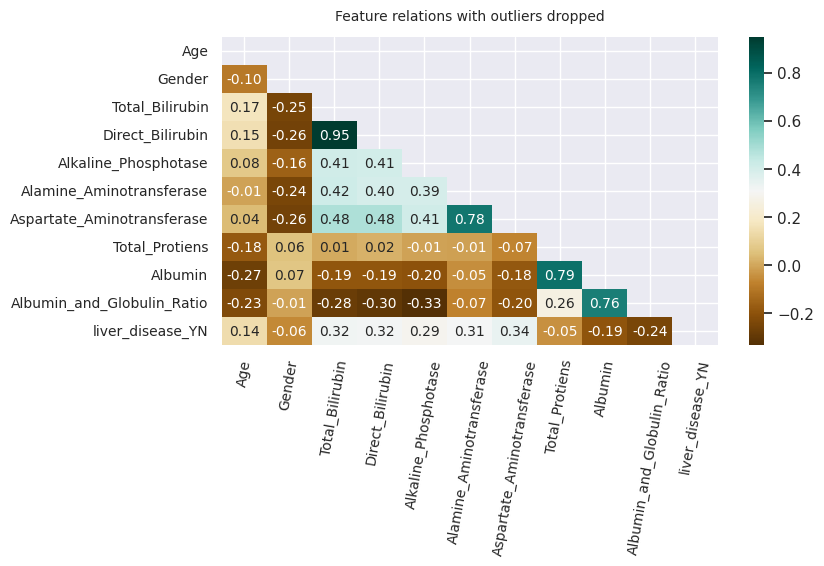

In [86]:
## df_outliers_dropped
plt.figure(figsize=(8, 4))
corr_map(df_outliers_dropped, 'Feature relations with outliers dropped')

#### As expected, 4 feature pairs (given below) are strongly correlated, with pair 3 having a near perfect positive correlation of 1.
    1. Albumin and Total_Protiens, 
    2. Albumin and Albumin_and_Globulin_Ratio,
    3. log_Total_Bilirubin and log_Direct_Bilirubin / Total_Bilirubin and Direct_Bilirubin ,
    4. log_Alamine_Aminotransferase and log_Aspartate_Aminotransferase / Alamine_Aminotransferase and Aspartate_Aminotransferase.

### Now that we've cleaned up our dataset and extracted some important insights and engineered the features, we will move on to model training and evaluation.

# 1.3 Model Training, Hyperparameter Tuning and Evaluation

* I will use AdaBoostClassifier and RandomForestClassifier for this task.

* Instead of train_test_split, I will use StratifiedKFold crss validation strategy.

* For hyperparameter tuning, I will use GridSearchCV.

* I will test these strategies for both log-normalized dataframe and outliers-dropped dataframe.

In [87]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

In [90]:
X = df.drop('liver_disease_YN', axis =1)
y = df['liver_disease_YN']
X_out_dropped =  df_outliers_dropped.drop('liver_disease_YN', axis =1)
y_out_dropped = df_outliers_dropped['liver_disease_YN']

In [89]:
# Initialize StratifiedKFold class
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

**1.3.1 Training AdaBoost Classifier**

In [97]:
## Log Normalized Dataset

## Define parameter grids for GridSearchCV for AdaBoost Classifier
adaboost= AdaBoostClassifier()
adaboost_params = {'n_estimators':[205, 210, 215, 220, 225], 'learning_rate':[1.7, 1.75, 1.8, 1.85, 1.9, 2]}

## GridSearchCV for AdaBoost Classifier
ada_grid = GridSearchCV(adaboost, adaboost_params, cv = skf, scoring = 'precision') 
#setting scoing to precision so as to reduce False negatives in disease detection
ada_grid.fit(X,y)

print(ada_grid.best_estimator_)
print('mean_test_score:\n',ada_grid.cv_results_['mean_test_score'])

AdaBoostClassifier(learning_rate=1.8, n_estimators=220)

mean_test_score:

 [0.76119736 0.76670334 0.7634738  0.7661688  0.7704282  0.74801378

 0.75303042 0.751944   0.75374083 0.76174942 0.76737029 0.76888878

 0.77538514 0.78058949 0.77713585 0.76402735 0.75873887 0.76062369

 0.75439158 0.75481335 0.77092061 0.77202631 0.76522047 0.76677569

 0.75869985 0.7122807  0.39802689 0.7122807  0.39802689 0.7122807 ]


In [98]:
## Outliers Dropped Dataset

## Define parameter grids for GridSearchCV for AdaBoost Classifier
adaboost= AdaBoostClassifier()
adaboost_params = {'n_estimators':[205, 210, 215, 220, 225], 'learning_rate':[1.7, 1.8, 1.85, 2, 2.25, 2.5, 2.75, 3]}

## GridSearchCV for AdaBoost Classifier
ada_grid2 = GridSearchCV(adaboost, adaboost_params, cv = skf, scoring = 'precision') 
#setting scoing to precision so as to reduce False negatives in disease detection
ada_grid2.fit(X_out_dropped,y_out_dropped)

print(ada_grid2.best_estimator_)
print('mean_test_score:\n',ada_grid2.cv_results_['mean_test_score'])

AdaBoostClassifier(learning_rate=2, n_estimators=210)

mean_test_score:

 [0.78429399 0.79000314 0.78994723 0.78473926 0.78114287 0.78051938

 0.79667394 0.7922555  0.7841397  0.79184437 0.77845427 0.78665689

 0.78556343 0.78130269 0.78368946 0.71828753 0.88091717 0.71828753

 0.88091717 0.71828753 0.719926   0.72344274 0.719926   0.72344274

 0.719926   0.719926   0.719926   0.719926   0.719926   0.719926

 0.719926   0.719926   0.719926   0.719926   0.719926   0.719926

 0.719926   0.719926   0.719926   0.719926  ]


**1.3.2 Training RandomForest Classifier**

In [99]:
## Log Normalized Dataset
## Define parameter grids for GridSearchCV for RandomForest Classifier
randomforest = RandomForestClassifier()
rf_params = {'max_depth': [None, 20, 25, 26, 27, 28], 'n_estimators':[200, 210, 215, 220, 225, 230], 'warm_start':[True, False]}

## GridSearchCV for RandomForest Classifier
rf_grid = GridSearchCV(randomforest, rf_params, cv = skf, scoring = 'precision')
rf_grid.fit(X,y)

print(rf_grid.best_estimator_)
print('mean_test_score:\n',rf_grid.cv_results_['mean_test_score'])

RandomForestClassifier(n_estimators=215)

mean_test_score:

 [0.74595222 0.74447686 0.75278842 0.75072079 0.7543341  0.76269359

 0.7485144  0.74427931 0.74309417 0.74330749 0.75014155 0.7498719

 0.75349494 0.74792503 0.75040873 0.74740887 0.73818919 0.75629875

 0.75588812 0.75503347 0.75397587 0.74247686 0.7451894  0.74824048

 0.75268404 0.75672758 0.74931341 0.75076949 0.75015133 0.75188662

 0.75524333 0.74912128 0.74770764 0.73503432 0.75185514 0.75087521

 0.74111003 0.75341235 0.74786696 0.75000875 0.75076008 0.7452151

 0.74453287 0.7474782  0.75248054 0.74817508 0.74840162 0.75086426

 0.74829372 0.74773519 0.74562407 0.75520429 0.75128788 0.74013385

 0.74939066 0.74948704 0.7461294  0.74489846 0.74270319 0.73960523

 0.7539718  0.74682651 0.75168779 0.75253498 0.75249524 0.75511406

 0.74722956 0.74528435 0.75272061 0.75241151 0.74241985 0.75048657]


In [101]:
## Outliers dropped Dataset

## Define parameter grids for GridSearchCV for RandomForest Classifier
randomforest = RandomForestClassifier()
rf_params = {'max_depth': [None,10, 15, 20, 25, 26], 'n_estimators':[180, 190, 200, 210, 215], 'warm_start':[True, False]}

## GridSearchCV for RandomForest Classifier
rf_grid2 = GridSearchCV(randomforest, rf_params, cv = skf, scoring = 'precision')
rf_grid2.fit(X_out_dropped,y_out_dropped)

print(rf_grid2.best_estimator_)
print('mean_test_score:\n',rf_grid2.cv_results_['mean_test_score'])

RandomForestClassifier(max_depth=15, n_estimators=200, warm_start=True)

mean_test_score:

 [0.76712432 0.76427205 0.76957998 0.76804804 0.7606246  0.76778043

 0.76652565 0.76089026 0.75910353 0.76754808 0.76332852 0.75964132

 0.76800753 0.76472895 0.74653539 0.76656838 0.76397269 0.76952521

 0.76266176 0.7573399  0.76697511 0.76638696 0.76391165 0.76309306

 0.78287963 0.76759245 0.77066479 0.76502216 0.76270099 0.77348581

 0.76065061 0.76980881 0.76599695 0.76820181 0.76043143 0.77110028

 0.76017536 0.77085514 0.75526988 0.77066387 0.76082672 0.76188775

 0.76788293 0.77429888 0.76750605 0.76372529 0.76832873 0.7771956

 0.76764317 0.7644606  0.76311184 0.76989644 0.77065684 0.76873965

 0.76839335 0.7615916  0.77434713 0.76175667 0.77004168 0.76779506]


#### **1.3.3 Model Evaluation**

In [118]:
## Evaluate the models using cross-validation scores

adaboost_log_norm_scores = ada_grid.cv_results_['mean_test_score']
adaboost_outliers_drop_scores = ada_grid2.cv_results_['mean_test_score']
rf_log_norm_scores = rf_grid.cv_results_['mean_test_score']
rf_outliers_drop_scores = rf_grid2.cv_results_['mean_test_score']

## Print the cross-validation scores
print("Cross-validation results for AdaBoostClassifier:")

print(f"Best parameters for Log_normed + AdaBoostClassifier: {ada_grid.best_params_}")
#print('AdaBoost LogNormed\n',adaboost_log_norm_scores, '\n\n')

print("Best parameters for Outliers_drop + AdaBoostClassifier:", ada_grid2.best_params_)
#print('AdaBoost outliers_dropped\n',adaboost_outliers_drop_scores, '\n\n')

print("\nCross-validation results for RandomForestClassifier:")

print("Best parameters for Log_normed +  RandomForestClassifier:", rf_grid.best_params_)
#print('RandomForest LogNormed\n',rf_log_norm_scores, '\n\n')

print("Best parameters for Outliers_drop + RandomForestClassifier:", rf_grid2.best_params_)
#print('RandomForest OutliersDropped\n',rf_outliers_drop_scores, '\n\n')

Cross-validation results for AdaBoostClassifier:

Best parameters for Log_normed + AdaBoostClassifier: {'learning_rate': 1.8, 'n_estimators': 220}

Best parameters for Outliers_drop + AdaBoostClassifier: {'learning_rate': 2, 'n_estimators': 210}



Cross-validation results for RandomForestClassifier:

Best parameters for Log_normed +  RandomForestClassifier: {'max_depth': None, 'n_estimators': 215, 'warm_start': False}

Best parameters for Outliers_drop + RandomForestClassifier: {'max_depth': 15, 'n_estimators': 200, 'warm_start': True}


In [120]:
print('Best Precision score with skewed features log normalized:')
print('AdaBoost:', np.max(adaboost_log_norm_scores))
print('RandomForest', np.max(rf_log_norm_scores))

Best Precision score with skewed features log normalized:

AdaBoost: 0.7805894943818507

RandomForest 0.7626935905656405


In [108]:
print('Best Precision score with outliers dropped:')
print('AdaBoost:', np.max(adaboost_outliers_drop_scores))
print('RandomForest', np.max(rf_outliers_drop_scores))

Best Precision score with outliers dropped:

AdaBoost: 0.8809171669483786

RandomForest 0.7828796313113597


# 1.4 Final Report and Conclusion: Comparison of Estimators
 After multiple rounds of hyperparameter tuning and refitting, we have found that **Adaboost Classifier is marginally better than Random Forest Classifier**. 
 
 **Dropping outliers massively improved the model precisions than simple log-normaliztion.**
 
 In GridSearchCV for both classifiers, I have chosen the value for **scoring as precision**, since my primary goal is **to minimize false negatives.** 

* **Hyperparameter tuning with log normalization** of heavily skewed features for AdaBoost and RandomForest Classifiers has **improved maximum mean precision scores of ~70% when fitted with default parameter values, to the the present maximum mean scores of 78% and 76% respectively.**

* **Hyperparameter tuning with outlier removal**  has shown **significant improvement in maximum mean precision scores for AdaBoost classifier from 78% to 88%, and RandomForest classifier from 76% to 78% respectively.**

 There might be a scope for improvement in model scores with a different set of classifier algorithms such as XGBoost, LightGBM, CatBoost. 

The **low maximum mean precision of <80% in RandomForest classifier can be explained** by our observation during EDA that there's a **significant overlap in the IQR of the boxplots** among features, when grouped by Gender and Liver_disease_YN feature. The **pairplots and correlation heatmaps have reconfirmed** this: the scatters and kde plots show significant overlaps, and low correlation among feature pairs.

While there exists **an argument that model precision can be improved by augmenting the data** with synthetic datapoints, I'm not exploring these strategies for the following reasons: 
* Firstly, oversampling strategies like ADASYN, SMOTE or SMOTENC may not work as they create point-bridges in the minority target class. We've observed that the minority and majority classes are **embedded and enmeshed deeply iside each other.** This is evident form the pairplots where distinct clusters are not visible. Using these may further deteriorate the predictive power of our model.
* Secondly, **undersampling causes a loss of information** as the dataset is small and so, this strategy is undesirable. 
* Lastly, I'm also not considering using the combination srategy of SMOTETomek since this too causes a loss in information in such a small dataset.

*If there is less of an overlap between the clusters based on target, intuition says,* **using BorderlineSMOTE with AdaBoost or its variant, the EasyEnsembleClassifier which uses AdaBoost as the base estimator will give a better model precision.** 

The **below combinations are recommended** for to be tested with different cross-validation strategies for arriving at better estimators and models.

1. SMOTENC + AdaBoostClassifier
2. SMOTENC + RandomForestClassifier, 
3. BorderlineSMOTE + AdaBoostClassifier,
4. BorderlineSMOTE + RandomForestClassifier
5. EasyEnsembleClassifier
6. BalancedRandomForestClassifier